In [9]:
# Instalar dependencias (ejecutar solo una vez)
!pip install ultralytics 
!pip install segment-anything 
!pip install opencv-python 
!pip install matplotlib
!pip install git+https://github.com/facebookresearch/segment-anything.git

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\ALEX\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\ALEX\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\ALEX\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\ALEX\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\alex\appdata\local\temp\pip-req-build-hsevmc6w
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\ALEX\AppData\Local\Temp\pip-req-build-hsevmc6w'

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\ALEX\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
# Descargar checkpoint de SAM (versión base)
!curl -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry
import os

In [22]:
# ------------------------------------------------------
# Funciones auxiliares
# ------------------------------------------------------
def calculate_iou(box1, box2):
    """Calcula la intersección sobre unión (IoU) entre dos cajas"""
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    
    # Área de intersección
    xi1 = max(x1_1, x1_2)
    yi1 = max(y1_1, y1_2)
    xi2 = min(x2_1, x2_2)
    yi2 = min(y2_1, y2_2)
    intersection = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    # Áreas individuales
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    
    return intersection / (area1 + area2 - intersection + 1e-6)

In [25]:
# ------------------------------------------------------
# Configuración inicial
# ------------------------------------------------------
image_path = "input.jpeg"
output_dir = "segments"
os.makedirs(output_dir, exist_ok=True)

# Cargar imagen
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)


In [26]:
# ------------------------------------------------------
# 1. Detección de objetos con YOLO
# ------------------------------------------------------
model_yolo = YOLO("yolov8x.pt") 
results = model_yolo(image)



0: 640x640 1 person, 1 cell phone, 899.1ms
Speed: 13.4ms preprocess, 899.1ms inference, 13.5ms postprocess per image at shape (1, 3, 640, 640)


In [27]:
allowed_classes = [
    'tie', 'car', 'truck', 'handbag', 'suitcase', 'bottle', 
    'wine glass', 'cup', 'fork', 'knife', 'spoon', 'clock', 
    'vase', 'teddy bear', 'hair drier', 'toothbrush', 'shoe',
    'hat', 'backpack', 'umbrella', 'book', 'cell phone'
]

In [28]:
# ------------------------------------------------------
# 2. Detectar objetos con YOLO
# ------------------------------------------------------

# Filtrar detecciones
filtered_boxes = []
filtered_classes = []
for box, cls_id in zip(results[0].boxes.xyxy.cpu().numpy(), results[0].boxes.cls.cpu().numpy()):
    class_name = results[0].names[int(cls_id)]
    if class_name.lower() in [c.lower() for c in allowed_classes]:
        filtered_boxes.append(box)
        filtered_classes.append(class_name)

print(f"Objetos relevantes detectados: {', '.join(filtered_classes)}")

Objetos relevantes detectados: cell phone


In [18]:
# ------------------------------------------------------
# 2. Configurar SAM con parámetros personalizados
# ------------------------------------------------------

# Inicializar SAM
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.92,
    stability_score_thresh=0.85,
    crop_n_layers=1,
    min_mask_region_area=100
)

# Generar todas las máscaras
masks = mask_generator.generate(image)


In [19]:
# ------------------------------------------------------
# 3. Filtrar máscaras usando YOLO
# ------------------------------------------------------
valid_segments = []
for mask in masks:
    # Obtener bbox de SAM
    x1, y1, w, h = mask["bbox"]
    sam_box = [x1, y1, x1 + w, y1 + h]
    
    # Comparar con todas las cajas de YOLO
    for yolo_box, class_name in zip(filtered_boxes, filtered_classes):
        iou = calculate_iou(sam_box, yolo_box)
        if iou > 0.4:  # Umbral de superposición
            valid_segments.append((mask, class_name))
            break

TypeError: SamPredictor.predict() got an unexpected keyword argument 'pred_iou_thresh'

In [ ]:
# ------------------------------------------------------
# 4. Guardar cada segmento como imagen individual
# ------------------------------------------------------
for idx, (segment, class_name) in enumerate(valid_segments):
    # Crear máscara binaria
    mask = segment["segmentation"]
    
    # Aplicar máscara a la imagen original
    masked_image = np.zeros_like(image)
    masked_image[mask] = image[mask]
    
    # Guardar con fondo transparente
    output_path = os.path.join(output_dir, f"{class_name}_{idx}.png")
    plt.imsave(output_path, masked_image, format='png', transparent=True)
    print(f"Segmento guardado: {output_path}")

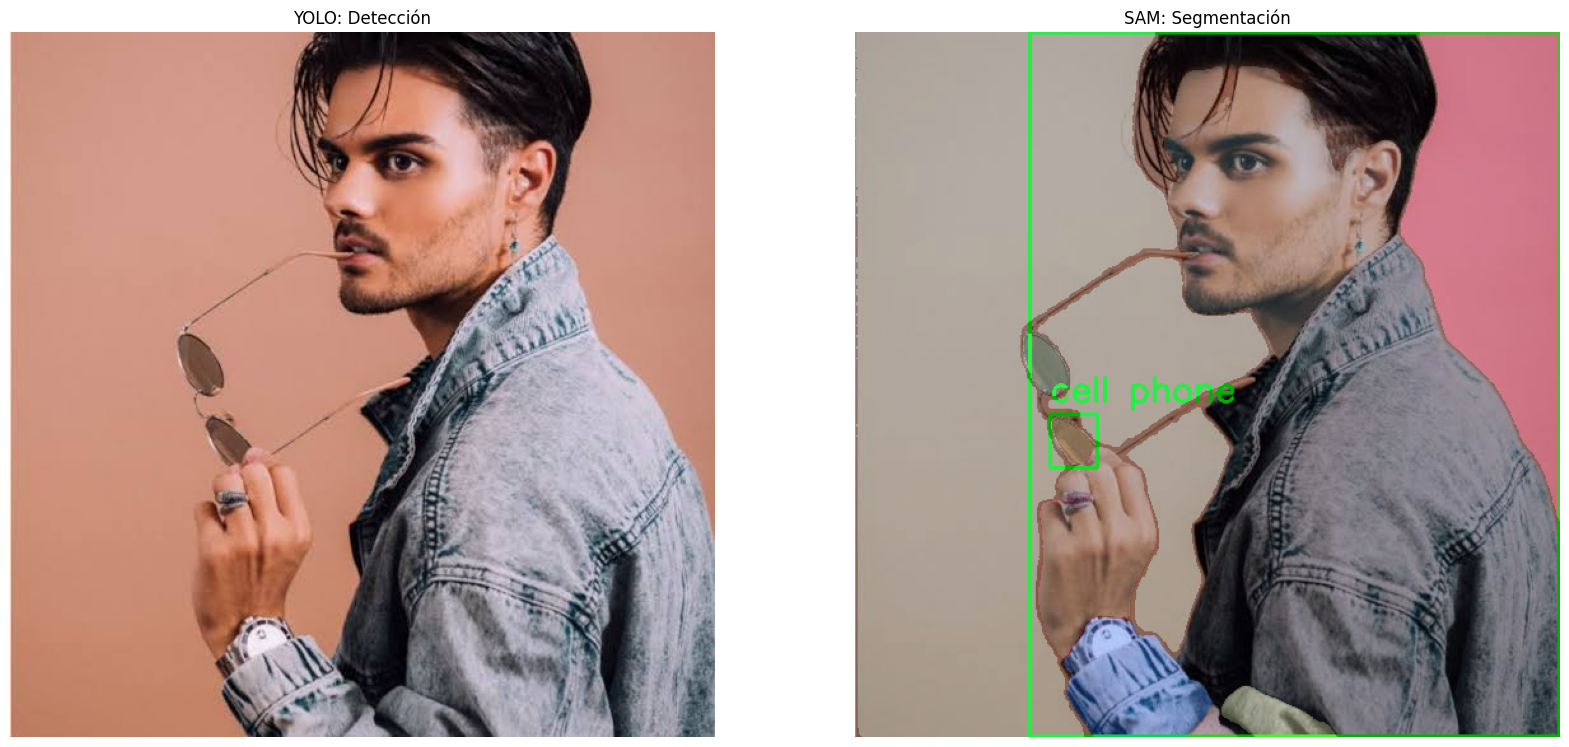

In [8]:
# ------------------------------------------------------
# 5. Mostrar ejemplo
# ------------------------------------------------------
if valid_segments:
    example_path = os.path.join(output_dir, f"{valid_segments[0][1]}_0.png")
    example_image = plt.imread(example_path)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(example_image)
    plt.title(f"Ejemplo: {valid_segments[0][1]}")
    plt.axis('off')
    plt.show()
else:
    print("No se encontraron objetos segmentados relevantes.")